# Construction of interference graphs for multipartite feed-forward networks

In [3]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

Generic import of functions related to path overlap et similia

In [4]:
from path_overlap import * 

Here we create a multipartite network with 3 layers, 5 dense units and 15 sparse ones.   
Dense units means that, for each pair of consecutive layers, for each pair of units taken from the 5 in the first layer and  the 5 in the second layer will be linked with probability "density". 
For illustration, we set the probability to 1 here, so all pairs are linked (it should be clear from the illustration below)

In [5]:
num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
num_layers = 3
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [6]:
pos = nx.multipartite_layout(MPG)

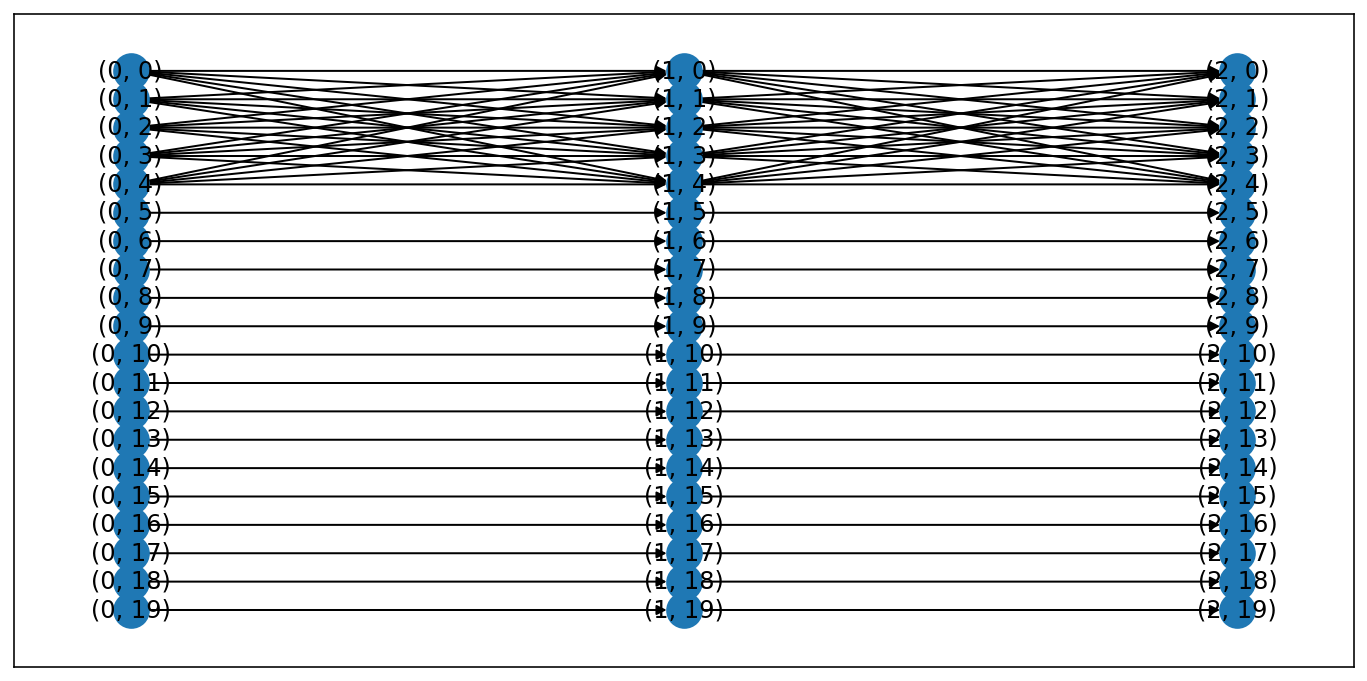

In [7]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

# Rewiring of the "perfect" MPG to create more varied MP graphs

The function below does exactly what the title says:
- for "rewire_iters" times, picks an edge;
- checks whether the indegree of the target node is larger than 1;
- if so, rolls a dice between 0 and 1, and if the probability is lower than "rewire_prob", changes the target node of the edge

In [8]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=100)

In [9]:
rew_pos = nx.multipartite_layout(rew_MPG)

And voila'... 

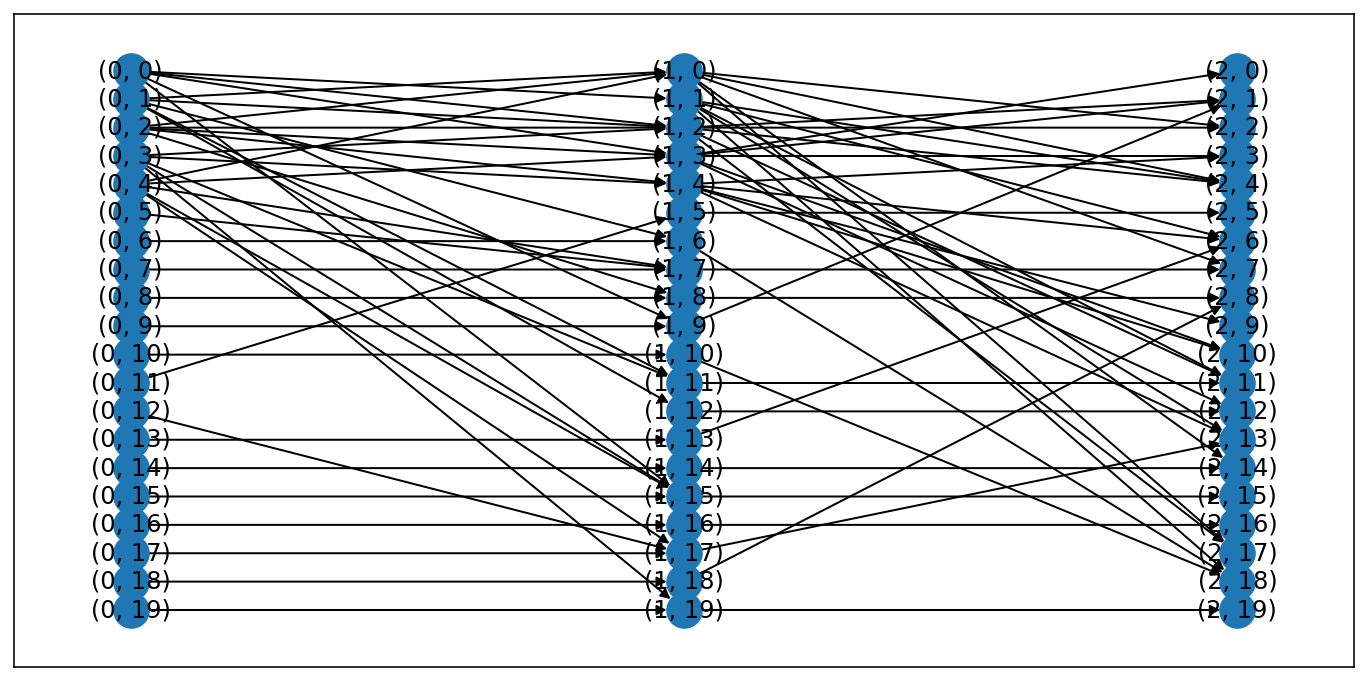

In [10]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

# Interference graphs at the level of task path families

We define a task path family as the set of paths starting at an input node $i$ and ending at an output node $o$.
Correspondingly the interference graph will have nodes that are labeled by the task path family $(i, o)$. 

In [69]:
IG, paths = MP_interference_graph(MPG)
rew_IG, rew_paths = MP_interference_graph(rew_MPG)

Note that it's possible to pass the pre-computed paths between task path families to the MP_interference_graph function. 
If it is not passed though, it computes it and returns is as part of the output (for your convenience. You're welcome..)

In [70]:
IG.number_of_edges(), rew_IG.number_of_edges()

(300, 1867)

16

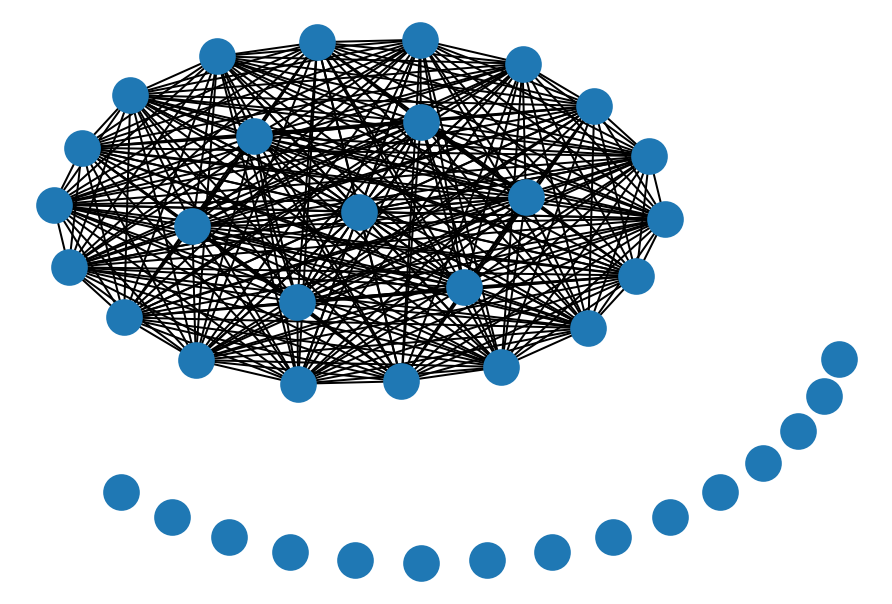

In [71]:
nx.draw_kamada_kawai(IG)
len(nx.maximal_independent_set(IG))

Note that interestingly there are 15 separated nodes that correspond to the "line paths" in the clean MPG, plus one performable extra task from the giga-blob

8

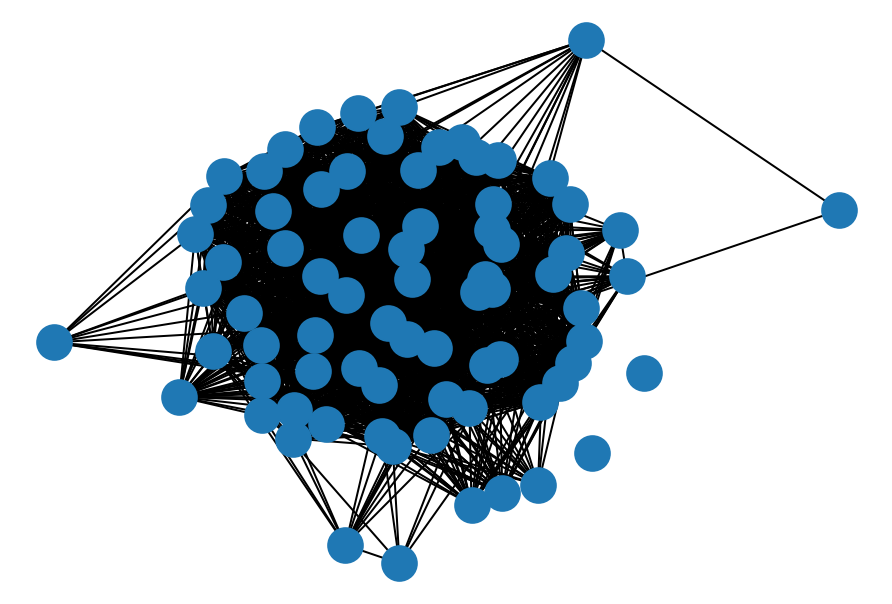

In [73]:
nx.draw_kamada_kawai(rew_IG)
len(nx.maximal_independent_set(rew_IG))

the situation instead becomes significantly more complex in the case of the rewired case.. and the MIS size (aka capacity) drops..

# Evolution of MIS as a function of rewiring

Below we illustrate this effect varying from the ordered (MPG) to the unordered (progressively more rewired MPG). 

In [74]:
num_iterations = 30
rw_it = 0.1
IG_dict = {}

num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
counts = {}
range_num_layers = [2, 3, 4]
capacity = {}
independent_paths = {}

for nl in tqdm(range_num_layers):
    capacity[nl] = {}
    IG_dict[nl] = {}
    independent_paths[nl] = {}
    tMPG = multipartite_network(nl, num_dense, num_sparse, density)    
    IG_dict[nl][0], instant_paths = MP_interference_graph(tMPG);
    instant_rew_MPG = tMPG.copy()
    counts[nl] = [0]
    for it in tqdm(range(1, num_iterations)):
        rw_it_num = int(instant_rew_MPG.number_of_edges() * rw_it) 
        instant_rew_MPG, instant_counts = rewire_multipartite_network(
            instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it_num, verbose=True)
        counts[nl].append(counts[nl][-1]+instant_counts)
        IG_dict[nl][it], instant_paths = MP_interference_graph(instant_rew_MPG)
        # For various reasons we compute here too the "effective capacity" and the number of independent paths
        # via the maximum flow (this is to relate to temporal network control --disclaimer: this is experimental, 
        # so just ignore it for now...--)
        capacity[nl][it]  = effective_capacity(instant_rew_MPG, instant_paths, sizes = [2,3], num_samples=4000)
        independent_paths[nl][it] = all_flows_MPG(instant_rew_MPG, instant_paths)

Text(0, 0.5, '|MIS|')

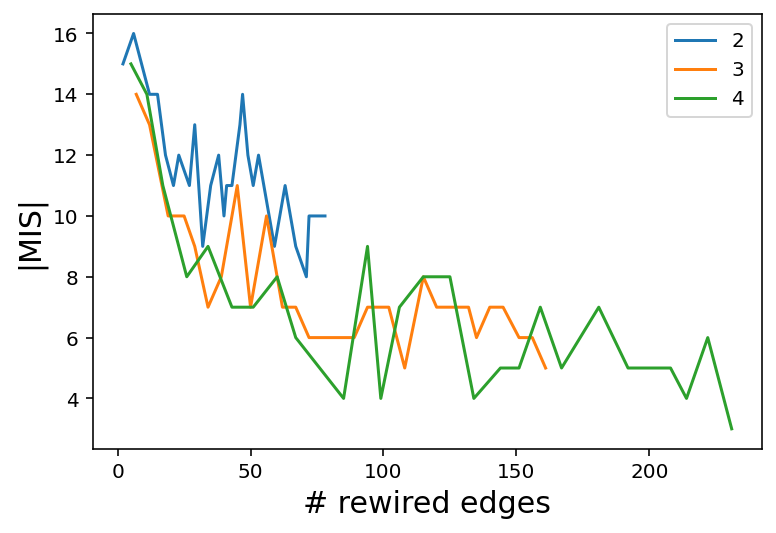

In [76]:
tot_interference = {}
for nl in range_num_layers:
    tot_interference[nl] = [len(nx.maximal_independent_set(nx.Graph(IG_dict[nl][x]))) for x in range(1, num_iterations)]
    plt.plot(counts[nl][1:], tot_interference[nl], label = nl)
plt.legend()
plt.xlabel('# rewired edges', fontsize=15)
plt.ylabel('|MIS|', fontsize=15)

Lo and behold, the more we rewire the smaller the MIS size... which is just a sanity check that a more integrated system has a lower maximum multitasking capacity (or at least it typically does..). 

We do see a small reduction in MIS size with increasing number of layers, but nothing major to be honest.  
**to be better explored**

Text(0.5, 1.0, 'Eff Capacity m=3')

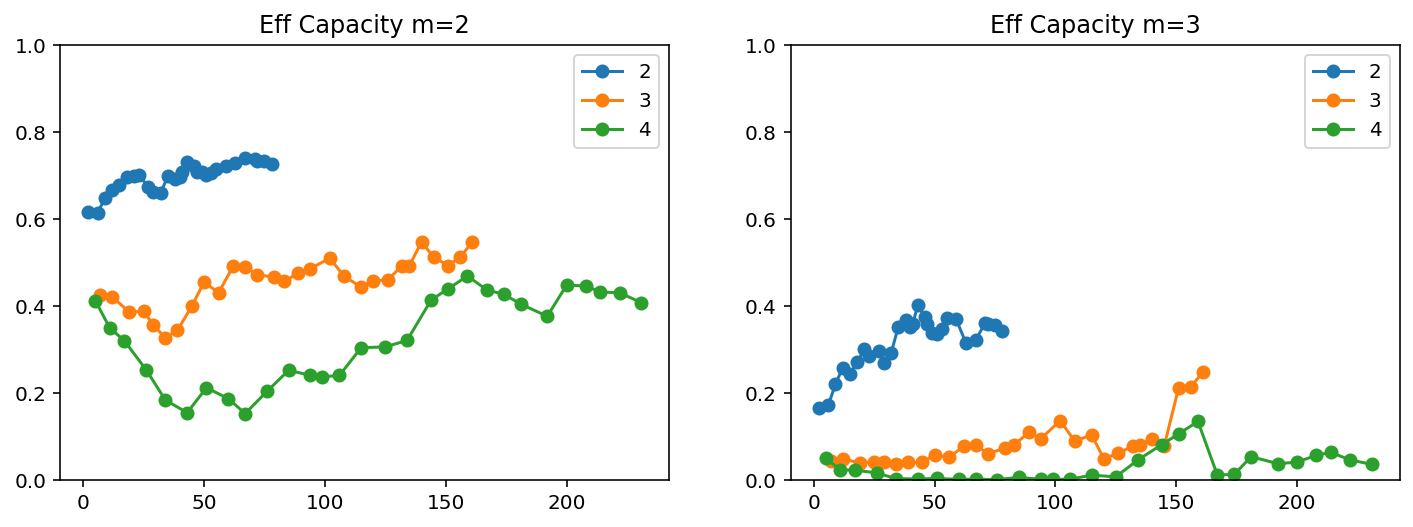

In [84]:
tot_capacity = {}
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for i, nl in enumerate(range_num_layers):
    tot_capacity[nl] = [1 - capacity[nl][x][2] for x in range(1,num_iterations)]
    plt.plot(counts[nl][1:], tot_capacity[nl], '-o', label = nl)
plt.legend()
plt.ylim(0,1)
plt.title('Eff Capacity m=2')

plt.subplot(1, 2, 2)
for i, nl in enumerate(range_num_layers):
    tot_capacity[nl] = [1 - capacity[nl][x][3] for x in range(1,num_iterations)]
    plt.plot(counts[nl][1:], tot_capacity[nl], '-o', label = nl)
plt.legend()
plt.ylim(0,1)
plt.title('Eff Capacity m=3')

Coolness! The same reduction with deeper networks **but more pronounced** can be seen for the effective capacity. 
Interestingly though, we see that some some interference graphs for rewired networks actually have larger effective capacity than the oroginal clean one.

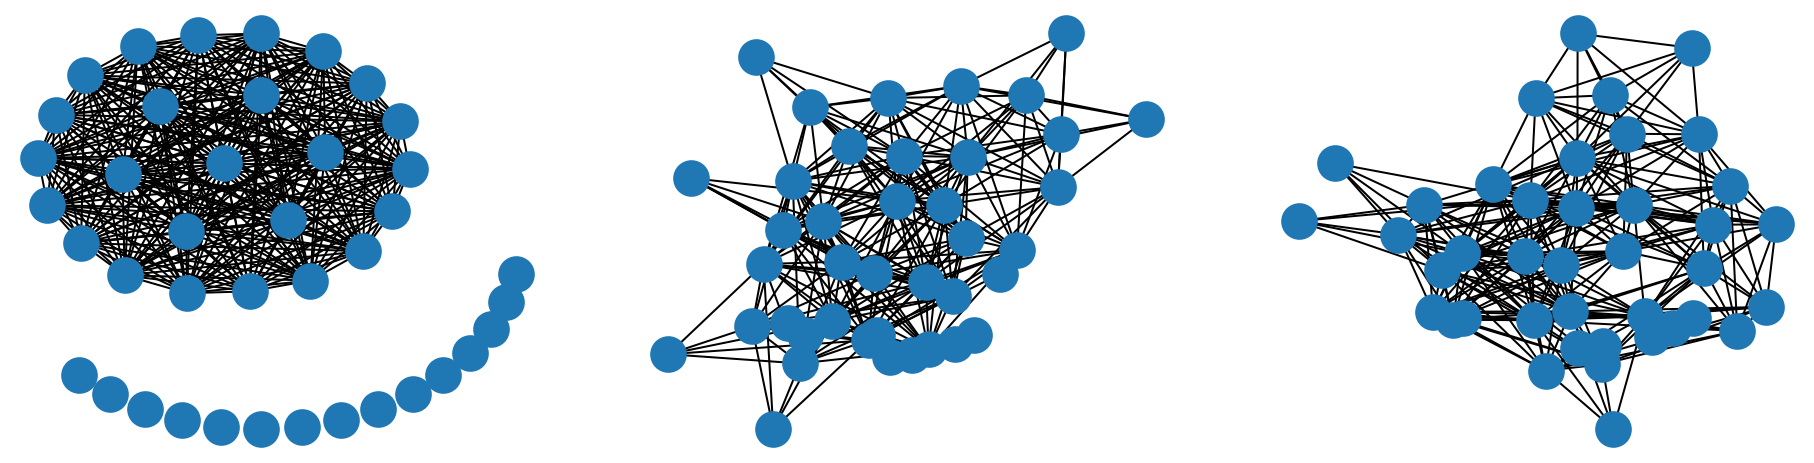

In [87]:
nums = [0, 7, 9]
fig = plt.figure(figsize=(16,4))
for i, n in enumerate(nums):
    plt.subplot(1, len(nums), i+1)
    nx.draw_kamada_kawai(IG_dict[2][n])

# Interference graphs at the level of task paths

We can define another task interference graph based now on the interference between actual paths, rather than between task path families.  

Naturally now the nodes won't be the $(i,o)$ pairs, but rather all the possible paths between all input and output nodes. 
Here again it is possible to pass the precomputed list of paths to the MP_task_interference_graph function, but you can be lazy and it will compute it for itself. 

In [89]:
MPT = MP_task_interference_graph(rew_MPG)

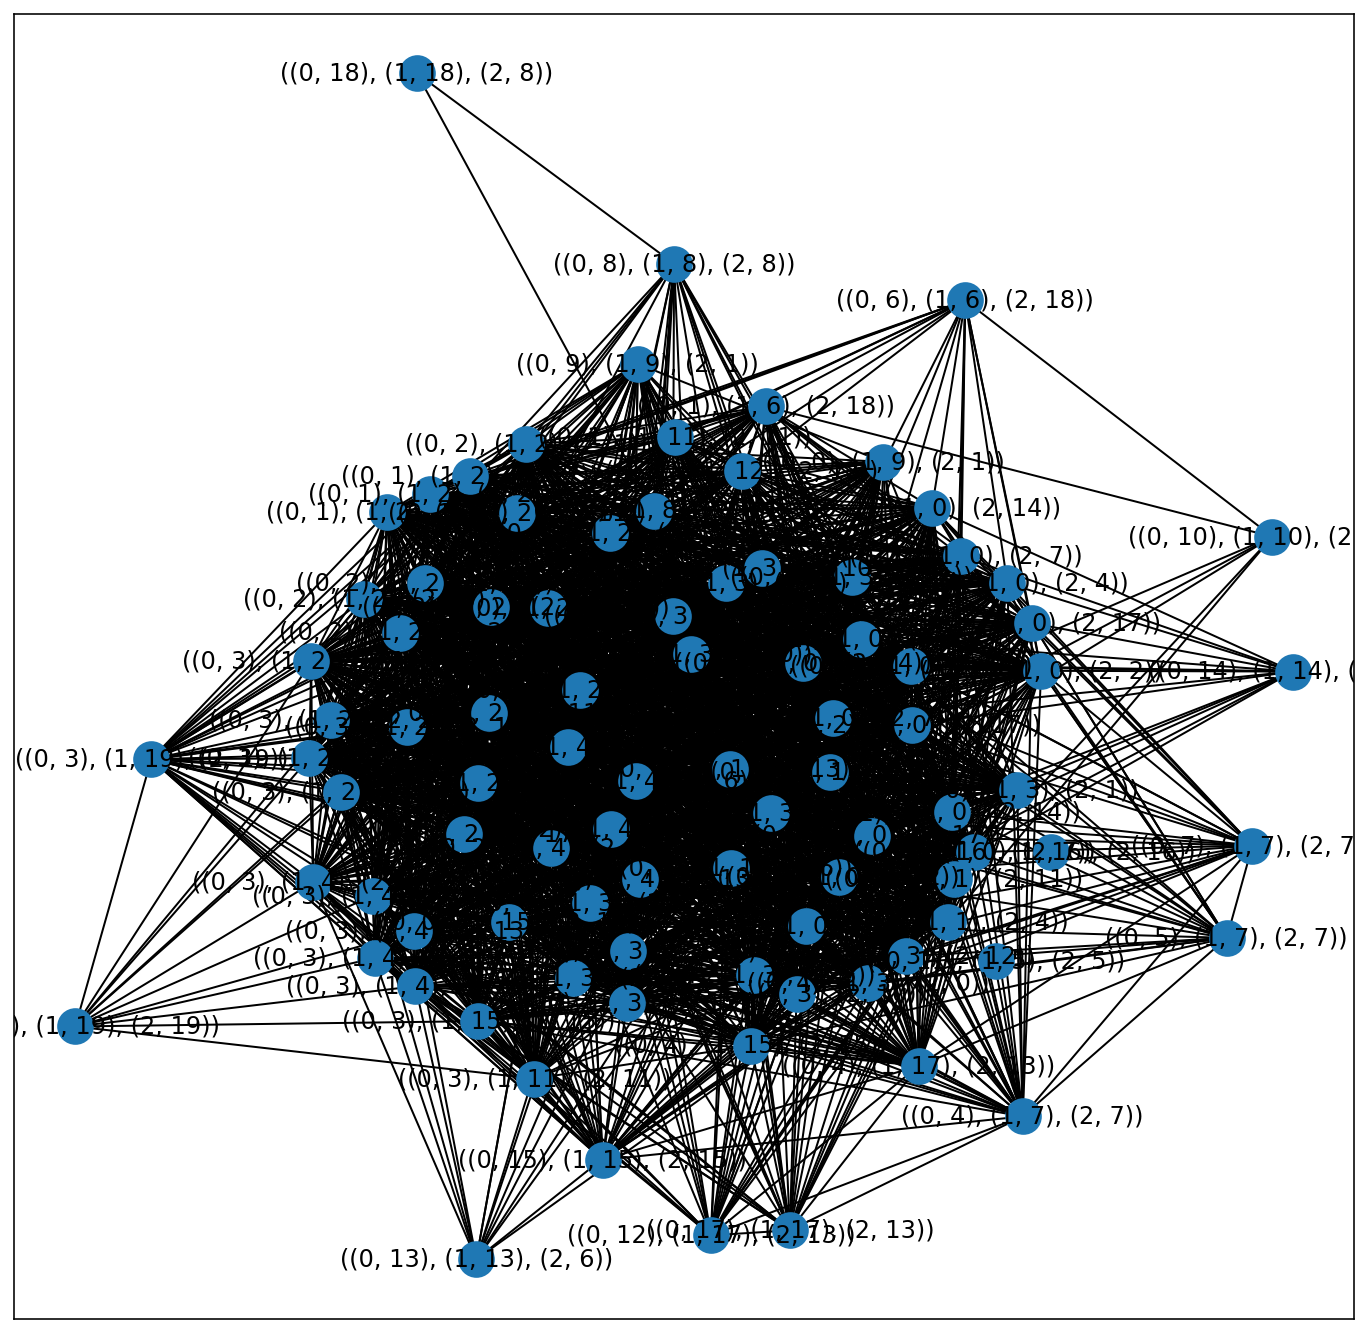

In [90]:
fig = plt.figure(figsize=(12,12))
pos_k = nx.kamada_kawai_layout(MPT[0])
nx.draw_networkx(MPT[0], pos=pos_k)

In [91]:
rew_IG = MP_interference_graph(rew_MPG)
len(nx.maximal_independent_set(MPT[0])), len(nx.maximal_independent_set(rew_IG[0]))

(10, 6)

The interference we are computing, that is the edges, actually come with a weight, in both types of interference graphs we are considering. 

In the task path interference graph, the weights count how many times two paths interfere with each other along the layers. 
This number is therefore an integer (as per current definition).

In the task path family interference graph, the weights count how many pairs of paths of the two families interfere with each other normalized by the total number of possible pairs. 
This number is instead a real between 0 and 1: it can be interpreted as the probability of interference when performing the tasks from the two corresponding task families. 
    


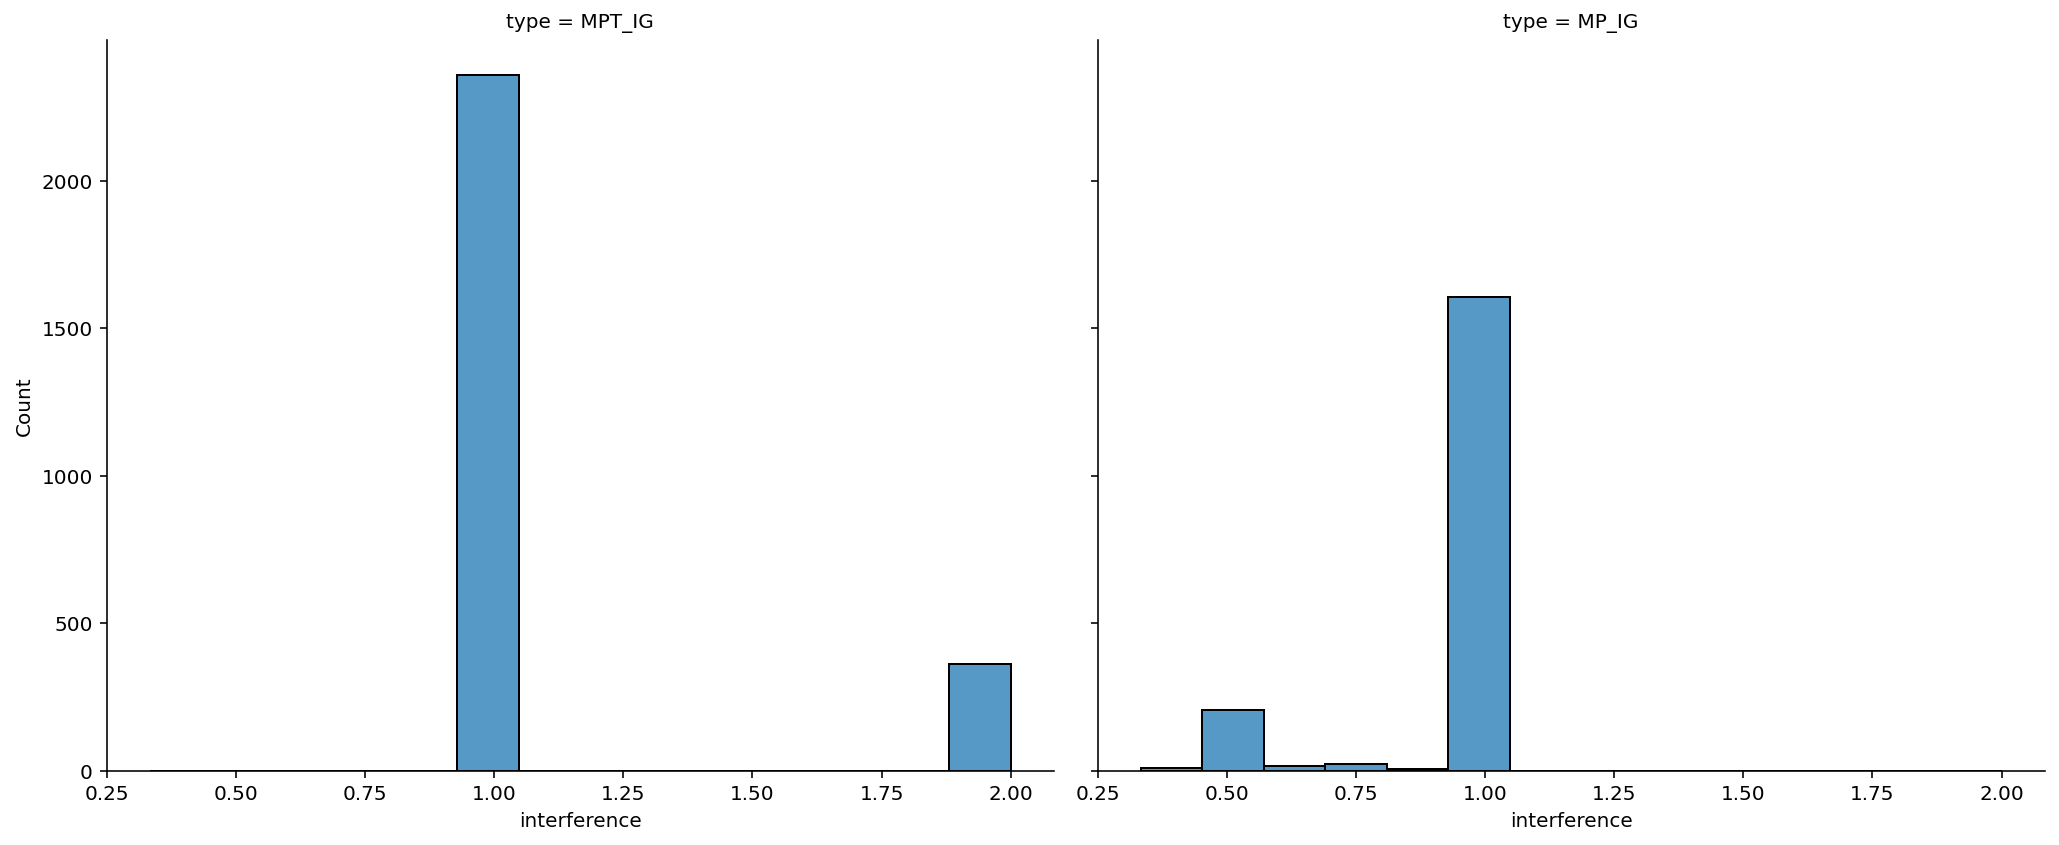

In [110]:
import seaborn as sns 
W = pd.DataFrame()
w, l = [], []

L = nx.get_edge_attributes(MPT[0], 'weight')
w = list(L.values())
l.extend(['MPT_IG']*len(L))

L = nx.get_edge_attributes(rew_IG[0], 'weight')
w.extend(list(L.values()))
l.extend(['MP_IG']*len(L))

W['interference'] = w;
W['type'] = l
         
sns.displot(data=W, x='interference', col='type', height=6, aspect=1.2)

## Relation between MIS size computed from interference graphs at the family and task levels

In [111]:
num_iterations = 10
rw_it = 0.1
IG_dict, tIG_dict = {}, {}

num_dense, num_sparse = 4, 12
tot_units = num_dense + num_sparse
density = 1
counts = {}
range_num_layers = [2, 3, 4, 5, 6]# 7, 8]
capacity = {}
independent_paths = {}

for nl in tqdm(range_num_layers):
    IG_dict[nl] = {}
    tIG_dict[nl] = {}
    tMPG = multipartite_network(nl, num_dense, num_sparse, density)    
    IG_dict[nl][0], instant_paths = MP_interference_graph(tMPG);
    instant_rew_MPG = tMPG.copy()
    counts[nl] = [0]
    for it in tqdm(range(1, num_iterations)):
        rw_it_num = int(instant_rew_MPG.number_of_edges() * rw_it) 
        instant_rew_MPG, instant_counts = rewire_multipartite_network(
            instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it_num, verbose=True)
        IG_dict[nl][it], instant_paths = MP_interference_graph(instant_rew_MPG)
        tIG_dict[nl][it] = MP_task_interference_graph(instant_rew_MPG, paths=instant_paths);
        


In [112]:
a, b = [], []
from scipy.stats import pearsonr, kendalltau
for nl in range_num_layers:
    al, bl = [], []
    for it in range(1, num_iterations):
        al.append(len(nx.maximal_independent_set(IG_dict[nl][it])))
        bl.append(len(nx.maximal_independent_set(tIG_dict[nl][it])))
    print(nl,  pearsonr(al, bl), kendalltau(al, bl))
    a.extend(al)
    b.extend(bl)
print('final',  pearsonr(a, b), kendalltau(a, b))

2 (0.6767124058509332, 0.04530016483960129) KendalltauResult(correlation=0.6064784348631228, pvalue=0.05146613916742822)
3 (0.9511897312113418, 8.063707847328583e-05) KendalltauResult(correlation=0.9090909090909091, pvalue=0.0012366410266029522)
4 (0.6268919021049439, 0.07079034459365541) KendalltauResult(correlation=0.5818573654517124, pvalue=0.044060987607269314)
5 (0.8640804132237174, 0.002661916186845293) KendalltauResult(correlation=0.7272727272727273, pvalue=0.00975958005870554)
6 (0.755742181606458, 0.018497315268386202) KendalltauResult(correlation=0.7006227308283303, pvalue=0.014339402743232345)
finale (0.8284383086620757, 2.1620964466182124e-12) KendalltauResult(correlation=0.7260723729435887, pvalue=1.3234230427944818e-10)


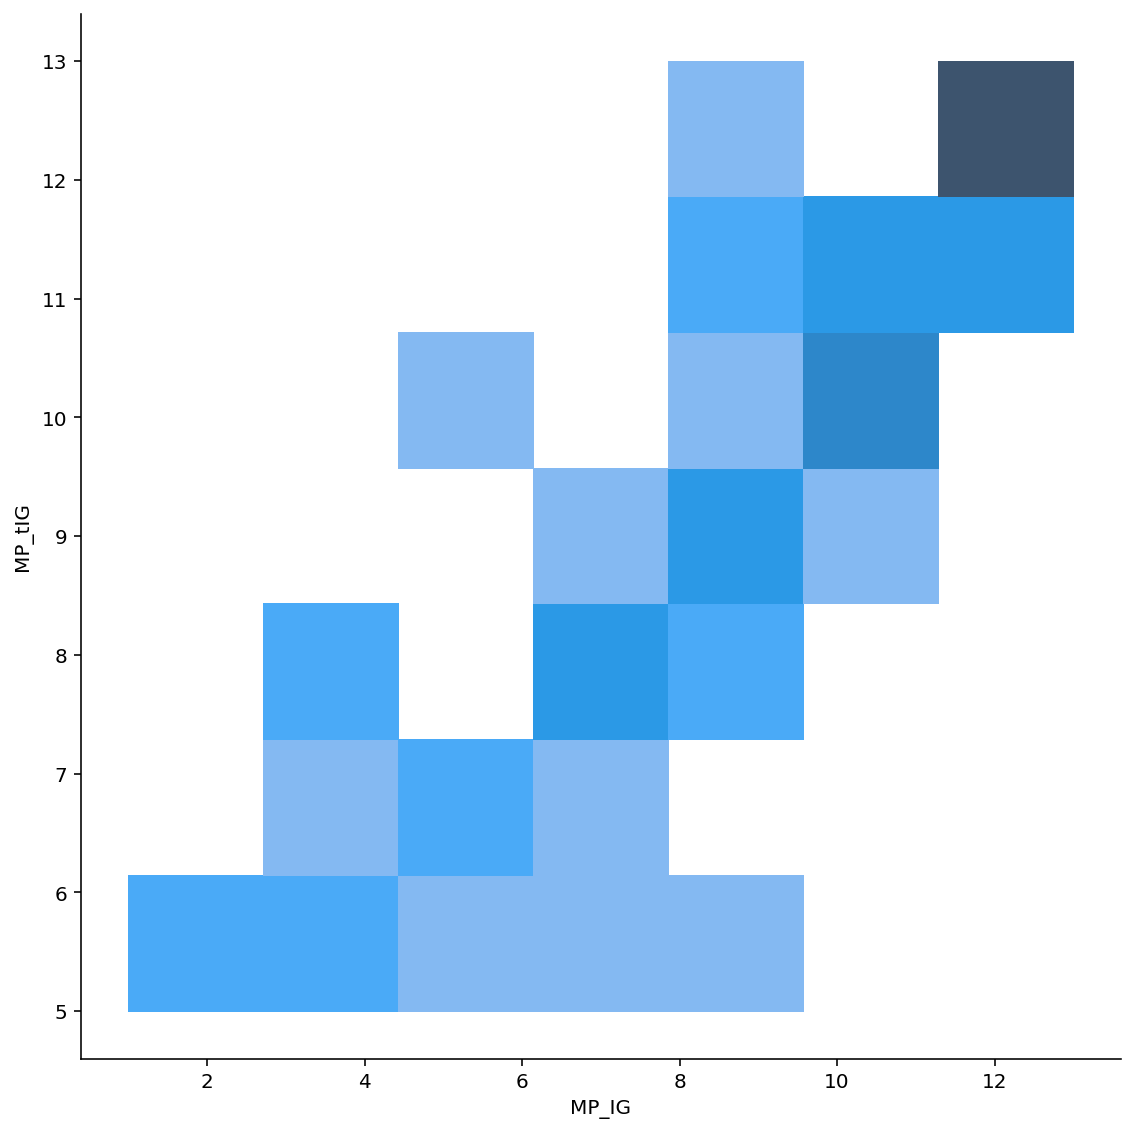

In [123]:
d = pd.DataFrame()
d['MP_IG'] = a
d['MP_tIG']= b
sns.displot(data=d, x='MP_IG', y='MP_tIG', height=8, aspect=1)